# **Goalkeeper Performance Analysis — Unsupervised Learning**

# 1. Introduction

This notebook explores goalkeeper statistics using unsupervised learning.  
We'll perform:
1. Descriptive Statistics & Data Exploration  
2. Feature Engineering  
3. Factorial Analysis (PCA)  
4. Clustering (K-Means)  
5. Deep Dive / Interpretation

*Tools Used:*
- pandas: data manipulation
- matplotlib, seaborn: visualization
- scikit-learn: PCA, clustering, scaling

**Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

In [2]:
# Configuration class to keep our paths and column names organized
class Config:
    path = "../data/"
    
sns.set_context("talk")

**Loading datasets and extracting data concerning goalkeepers**
- goalkeeping.csv
- distribution.csv
- disciplinary.csv
- key_stats.csv

In [3]:
# Store the filenames in a dictionary
files = {
    "goalkeeping": "goalkeeping.csv",
    "distribution": "distributon.csv",
    "disciplinary": "disciplinary.csv",
    "key_stats": "key_stats.csv"
}

# Read all datasets into a dictionary of DataFrames
dataframes = {name: pd.read_csv(Config.path + filename) for name, filename in files.items()}

# extracting goalkeepers in each dataframe
goalkeepers = {name: df[df['position'] == 'Goalkeeper'] for name, df in dataframes.items()}

# deleting the serial and position columns in all dataframes if it exists
for name in goalkeepers:
    if 'serial' in goalkeepers[name].columns:
        goalkeepers[name] = goalkeepers[name].drop(columns=['serial'])
    if 'position' in goalkeepers[name].columns:
        goalkeepers[name] = goalkeepers[name].drop(columns=['position'])

# merging all dataframes on 'player_name', 'club' and 'match_played'
for name in goalkeepers:
    if name != 'goalkeeping':
        goalkeepers['goalkeeping'] = pd.merge(goalkeepers['goalkeeping'], goalkeepers[name], on=['player_name', 'club', 'match_played'], how='left')
        
# sorting the final dataframe
df = goalkeepers['goalkeeping'].sort_values('player_name').reset_index(drop=True)

**Datasets Overview**

In [4]:
# Display the shape of each dataframe
for name in goalkeepers:
    print(f"{name} dataset shape: {goalkeepers[name].shape}")

print(f"Merged goalkeeping dataset shape: {df.shape}")

goalkeeping dataset shape: (53, 24)
distribution dataset shape: (50, 10)
disciplinary dataset shape: (2, 8)
key_stats dataset shape: (54, 7)
Merged goalkeeping dataset shape: (53, 24)


In [5]:
# Display the first few rows of each DataFrame
for name in goalkeepers:
    print(f"\n{name} dataset preview:")
    print(goalkeepers[name].head())

print("\nMerged goalkeeping dataset preview:")    
print(df.head())


goalkeeping dataset preview:
    player_name         club  saved  conceded  saved_penalties  cleansheets  \
0      Courtois  Real Madrid     61        14                1            5   
1         Rulli   Villarreal     41        16                0            3   
2   Vlachodimos      Benfica     38        17                1            5   
3  Athanasiadis      Sheriff     29         8                0            1   
4      Mignolet  Club Brugge     28        20                0            0   

   punches made  match_played  pass_accuracy  pass_attempted  ...  \
0             4            13           76.7           483.0  ...   
1            12            12           68.2           489.0  ...   
2             5            10           73.8           345.0  ...   
3             2             5           69.2           154.0  ...   
4             1             6           78.7           216.0  ...   

   freekicks_taken  fouls_committed  fouls_suffered  red  yellow  \
0           

In [6]:
# Display the last few rows of each DataFrame
for name in goalkeepers:
    print(f"\n{name} dataset tail:")
    print(goalkeepers[name].tail())
    
print("\nMerged goalkeeping dataset tail:")
print(df.tail())


goalkeeping dataset tail:
   player_name              club  saved  conceded  saved_penalties  \
48    Martínez           Leipzig      3         0                0   
49       Onana              Ajax      2         2                0   
50       Perin          Juventus      2         0                0   
51  Shevchenko  Shakhtar Donetsk      1         1                0   
52      Carson         Man. City      1         0                0   

    cleansheets  punches made  match_played  pass_accuracy  pass_attempted  \
48            1             0             1           54.0            28.0   
49            0             0             2           88.0            56.0   
50            1             0             1           79.0            19.0   
51            0             0             1            NaN             NaN   
52            1             0             1            NaN             NaN   

    ...  freekicks_taken  fouls_committed  fouls_suffered  red  yellow  \
48  ...  

# 2. Descriptive Statistics / Data Exploration / Feature Engineering

In [7]:
# Basic info about the merged dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   player_name       53 non-null     object 
 1   club              53 non-null     object 
 2   saved             53 non-null     int64  
 3   conceded          53 non-null     int64  
 4   saved_penalties   53 non-null     int64  
 5   cleansheets       53 non-null     int64  
 6   punches made      53 non-null     int64  
 7   match_played      53 non-null     int64  
 8   pass_accuracy     50 non-null     float64
 9   pass_attempted    50 non-null     float64
 10  pass_completed    50 non-null     float64
 11  cross_accuracy    50 non-null     float64
 12  cross_attempted   50 non-null     float64
 13  cross_complted    50 non-null     float64
 14  freekicks_taken   50 non-null     float64
 15  fouls_committed   2 non-null      float64
 16  fouls_suffered    2 non-null      float64
 17 

In [8]:
# Descriptive statistics of the merged dataframe
print(df.describe().T)

                  count        mean         std    min      25%     50%  \
saved              53.0   13.528302   11.025502    1.0    5.000   13.00   
conceded           53.0    7.169811    5.158025    0.0    3.000    6.00   
saved_penalties    53.0    0.113208    0.319878    0.0    0.000    0.00   
cleansheets        53.0    1.320755    1.541398    0.0    0.000    1.00   
punches made       53.0    2.075472    2.622749    0.0    0.000    1.00   
match_played       53.0    4.773585    3.394801    1.0    2.000    5.00   
pass_accuracy      50.0   77.092000   11.083005   50.7   70.625   77.65   
pass_attempted     50.0  160.020000  120.772765   19.0   58.500  153.50   
pass_completed     50.0  123.220000   96.178467   15.0   48.250  103.50   
cross_accuracy     50.0    0.000000    0.000000    0.0    0.000    0.00   
cross_attempted    50.0    0.020000    0.141421    0.0    0.000    0.00   
cross_complted     50.0    0.000000    0.000000    0.0    0.000    0.00   
freekicks_taken    50.0  

Number of duplicated rows: 0


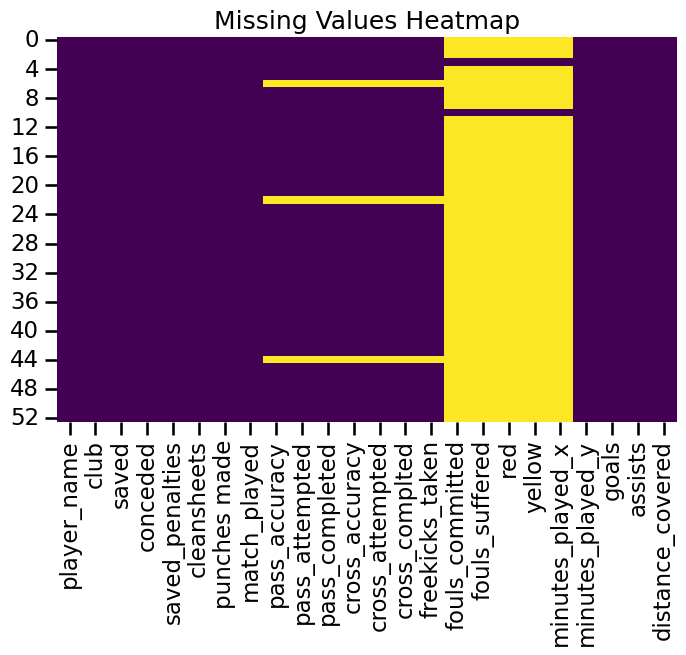

In [9]:
# Duplicated rows analysis
print(f"Number of duplicated rows: {df.duplicated().sum()}")

# Visualizing missing values
plt.figure(figsize=(8, 5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [10]:
# Converting appropriate columns to numeric types
df['distance_covered'] = pd.to_numeric(df['distance_covered'], errors='coerce')

**Handling missing data and taking care of duplicated columns**

- Duplicated columns that occur due to merging will be dropped since they contain the same information
- The missing values are replaced with 0 because they are *structurally missing data*. For example not all goalkeepers recieved yellow or red cards.

In [11]:
#df = df.dropna(axis=1, thresh=int(0.7 * len(df)))  # Drop columns with more than 30% missing values
df.drop(columns=['minutes_played_x'], inplace=True)
df.rename(columns={'minutes_played_y': 'minutes_played'}, inplace=True)

df = df.fillna(0)  # Fill remaining missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   player_name       53 non-null     object 
 1   club              53 non-null     object 
 2   saved             53 non-null     int64  
 3   conceded          53 non-null     int64  
 4   saved_penalties   53 non-null     int64  
 5   cleansheets       53 non-null     int64  
 6   punches made      53 non-null     int64  
 7   match_played      53 non-null     int64  
 8   pass_accuracy     53 non-null     float64
 9   pass_attempted    53 non-null     float64
 10  pass_completed    53 non-null     float64
 11  cross_accuracy    53 non-null     float64
 12  cross_attempted   53 non-null     float64
 13  cross_complted    53 non-null     float64
 14  freekicks_taken   53 non-null     float64
 15  fouls_committed   53 non-null     float64
 16  fouls_suffered    53 non-null     float64
 17 

**Vizualisation**

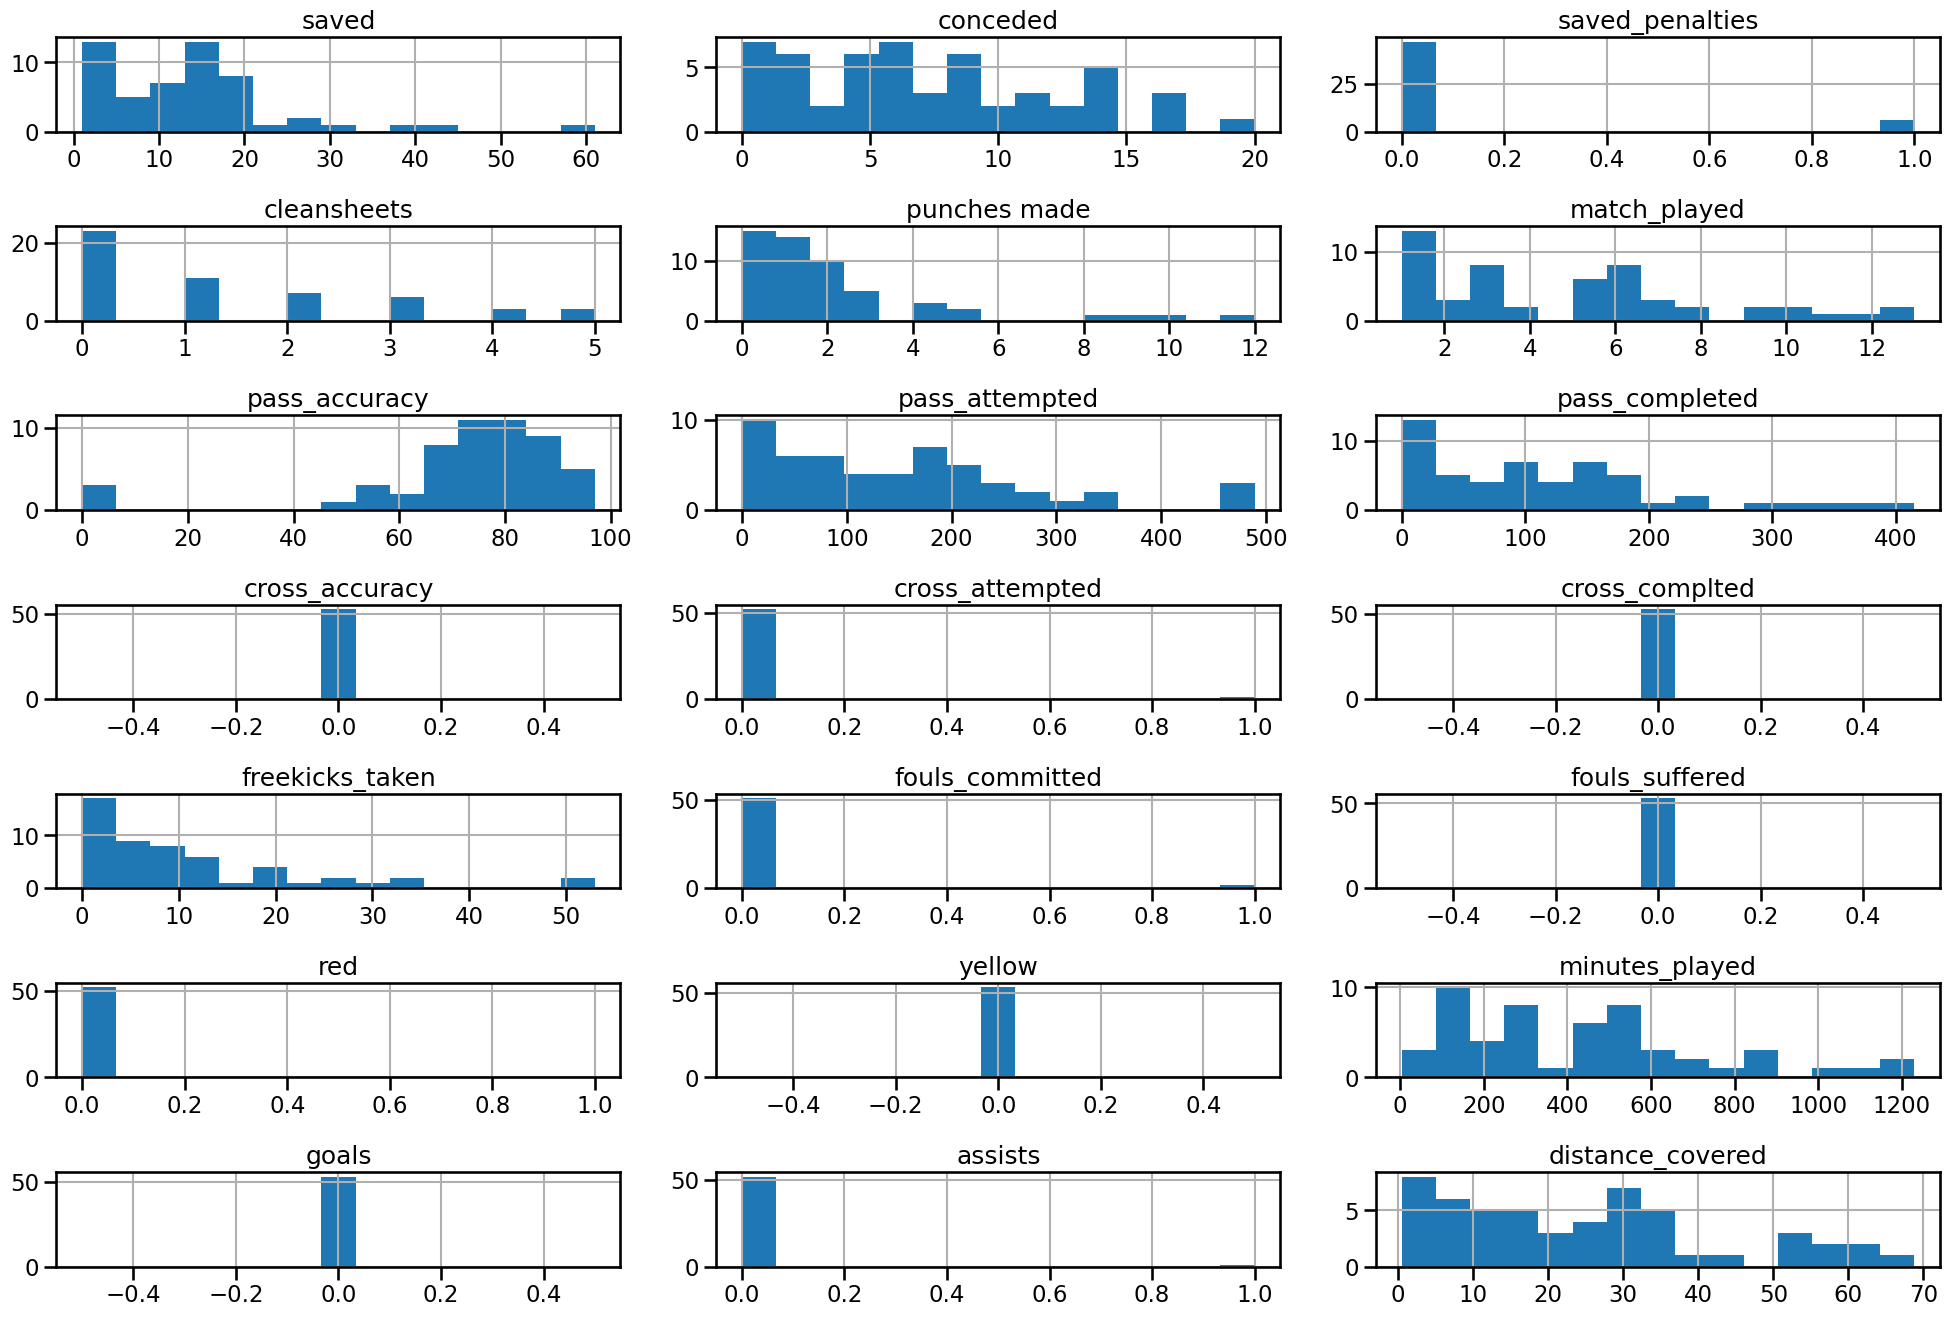

In [12]:
# Histogram of numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].hist(bins=15, figsize=(20, 15), layout=(len(numeric_cols)//3 + 1, 3))
plt.tight_layout()
plt.show()

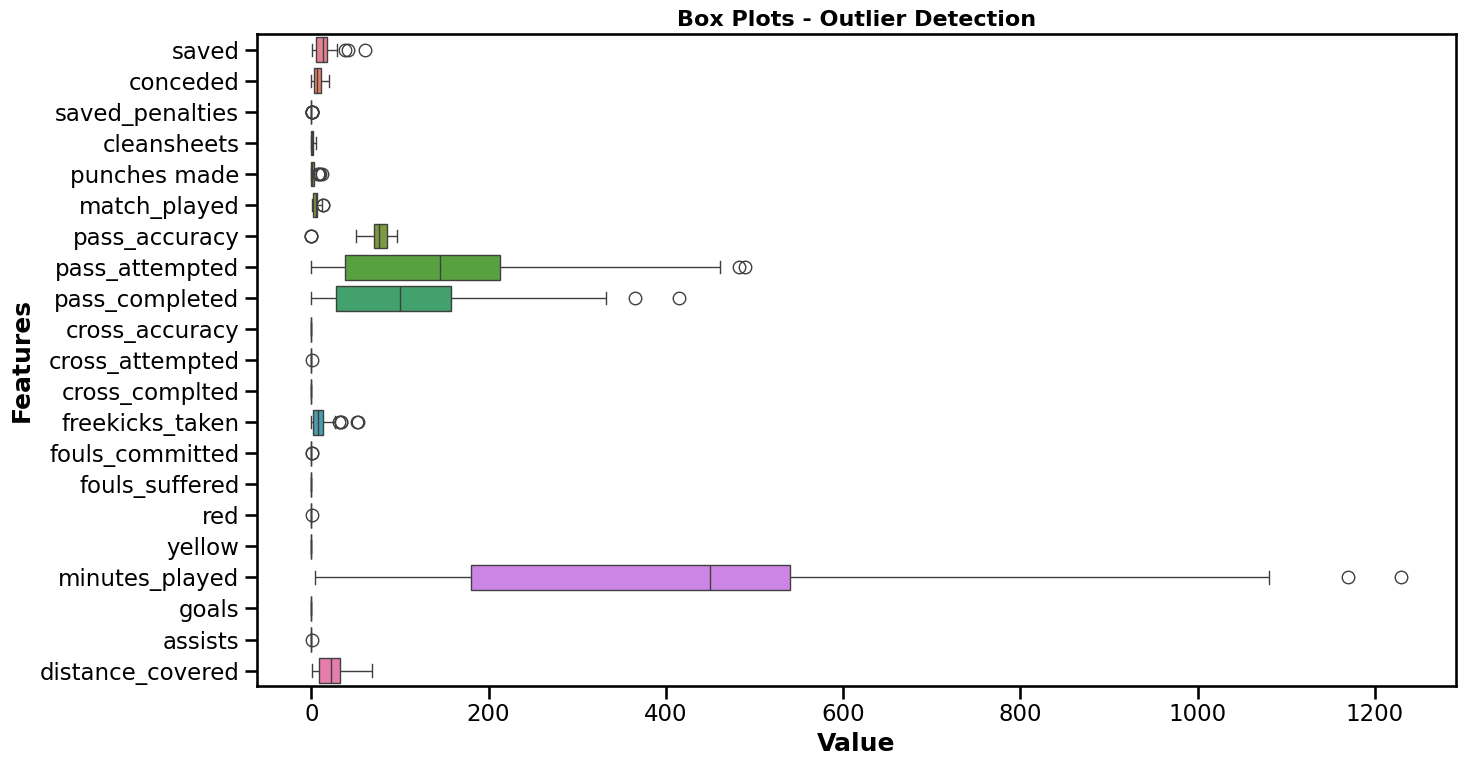

In [13]:
# Boxplots to detect outliers
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[numeric_cols], orient='h')
plt.xlabel('Value', fontweight='bold')
plt.ylabel('Features', fontweight='bold')
plt.title('Box Plots - Outlier Detection', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

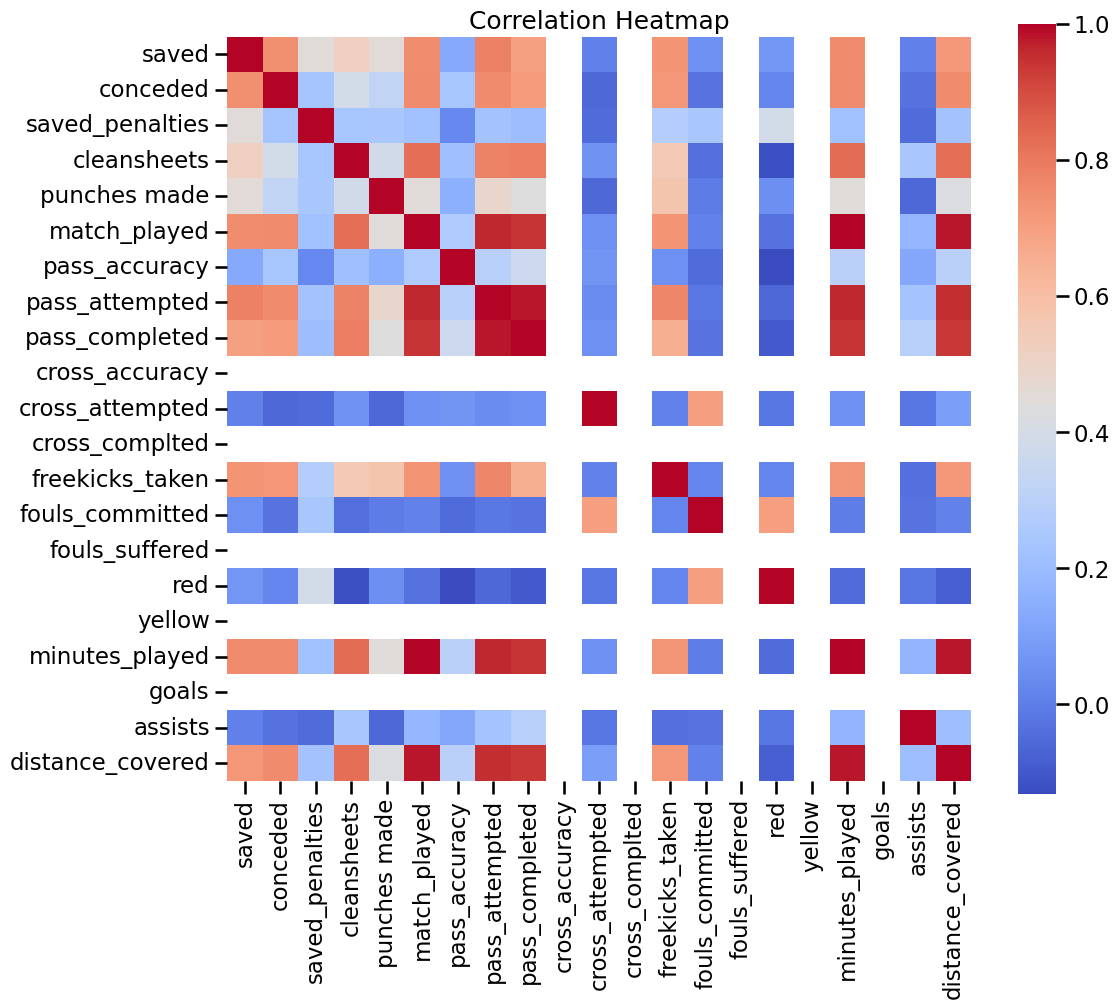

In [14]:
# Correlation matrix heatmap
plt.figure(figsize=(12,10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.show()

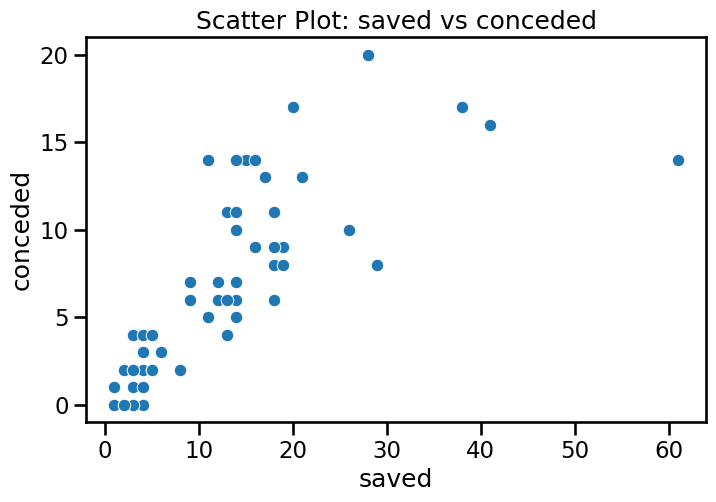

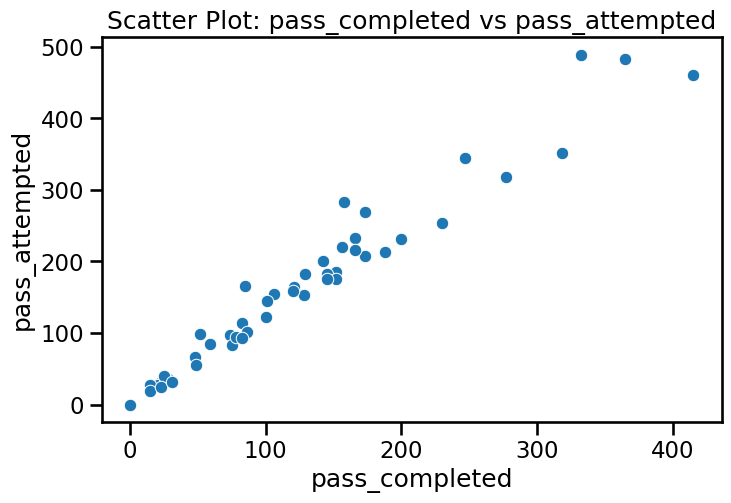

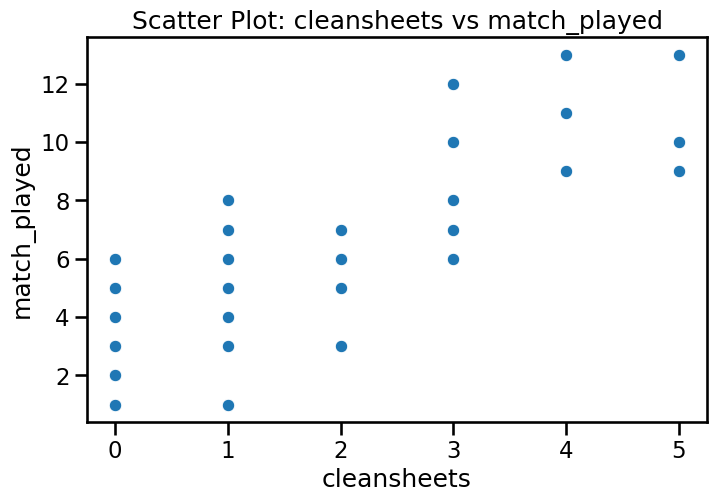

In [15]:
# Scatter plots for selected feature pairs
feature_pairs = [('saved', 'conceded'), ('pass_completed', 'pass_attempted'), ('cleansheets', 'match_played')]
for x_feature, y_feature in feature_pairs:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=x_feature, y=y_feature)
    plt.title(f'Scatter Plot: {x_feature} vs {y_feature}')
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.show()

In [16]:
# Deleting the goals column as it is not relevant for goalkeepers
df = df.drop(columns=['goals'])

# Dropping fouls suffered, cross_attempted and assists as they are very sparse and not relevant for goalkeepers
df = df.drop(columns=['fouls_suffered', 'cross_attempted', 'assists'])

In [17]:
# Creating a variable disciplinary to  keep disciplinary info as a single binary feature
df['disciplinary'] = np.where((df['fouls_committed'] > 0) | (df['yellow'] > 0) | (df['red'] > 0), 1, 0)
df = df.drop(columns=['yellow', 'red', 'fouls_committed'])

In [18]:
# Dropping columns with zero variance
df = df.loc[:, df.nunique() > 1]
print(f"Dataframe shape after {df.shape}")
df.columns

Dataframe shape after (53, 15)


Index(['player_name', 'club', 'saved', 'conceded', 'saved_penalties',
       'cleansheets', 'punches made', 'match_played', 'pass_accuracy',
       'pass_attempted', 'pass_completed', 'freekicks_taken', 'minutes_played',
       'distance_covered', 'disciplinary'],
      dtype='object')

In [19]:
# # Creating new features and normalizing per 90 minutes played
# df['pass_success_rate'] = (df['pass_completed'] / df['pass_attempted']) * 100
# df['saves_per_90'] = (df['saved'] / df['minutes_played']) * 90
#df['clean_sheets_per_match'] = (df['cleansheets'] / df['match_played'])
# df['conceded_per_90'] = (df['conceded'] / df['minutes_played']) * 90
# df['punches_per_90'] = (df['punches made'] / df['minutes_played']) * 90
# df['distance_per_90'] = (df['distance_covered'] / df['minutes_played']) * 90
# df['pass_attempted_per_90'] = (df['pass_attempted'] / df['minutes_played']) * 90
# df['freekicks_taken_per_90'] = (df['freekicks_taken'] / df['minutes_played']) * 90

In [20]:
# # Dropping original columns used to create new features
# df = df.drop(columns=['pass_completed', 'saved', 'cleansheets', 'conceded', 'punches made', 'distance_covered', 'pass_attempted', 'freekicks_taken', 'minutes_played'])

# # Dropping pass_accuracy as it is redundant with pass_success_rate
# df = df.drop(columns=['pass_accuracy'])

# # Displaying remaining columns
# df.columns

In [21]:
# missing values check
print(df.isnull().sum())

player_name         0
club                0
saved               0
conceded            0
saved_penalties     0
cleansheets         0
punches made        0
match_played        0
pass_accuracy       0
pass_attempted      0
pass_completed      0
freekicks_taken     0
minutes_played      0
distance_covered    0
disciplinary        0
dtype: int64


In [22]:
# Handling any remaining missing values
df = df.fillna(0)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   player_name       53 non-null     object 
 1   club              53 non-null     object 
 2   saved             53 non-null     int64  
 3   conceded          53 non-null     int64  
 4   saved_penalties   53 non-null     int64  
 5   cleansheets       53 non-null     int64  
 6   punches made      53 non-null     int64  
 7   match_played      53 non-null     int64  
 8   pass_accuracy     53 non-null     float64
 9   pass_attempted    53 non-null     float64
 10  pass_completed    53 non-null     float64
 11  freekicks_taken   53 non-null     float64
 12  minutes_played    53 non-null     int64  
 13  distance_covered  53 non-null     float64
 14  disciplinary      53 non-null     int64  
dtypes: float64(5), int64(8), object(2)
memory usage: 6.3+ KB


**Vizualisation**

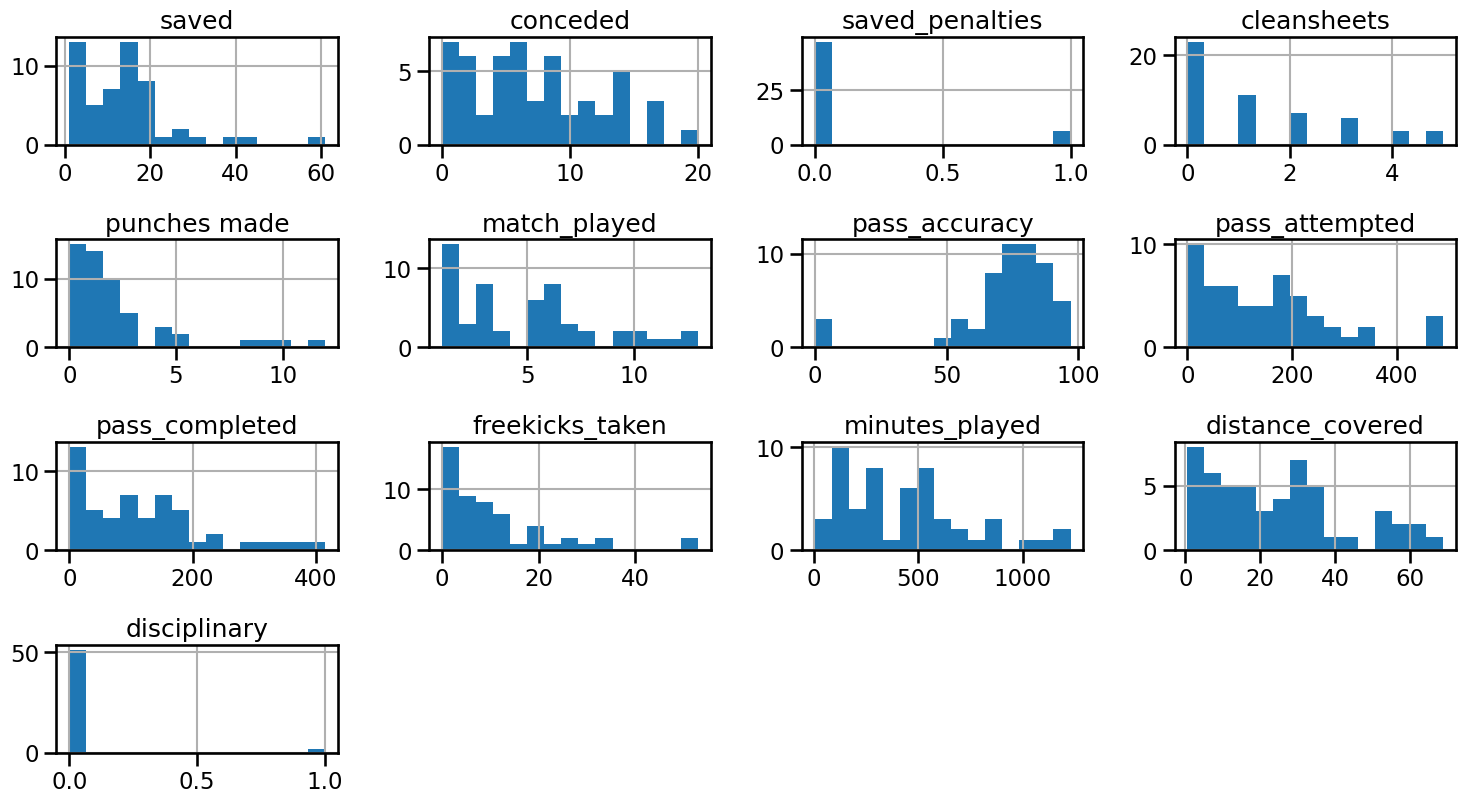

In [24]:
# Histogram of numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].hist(bins=15, figsize=(15, 10), layout=(5, 4))
plt.tight_layout()
plt.show()

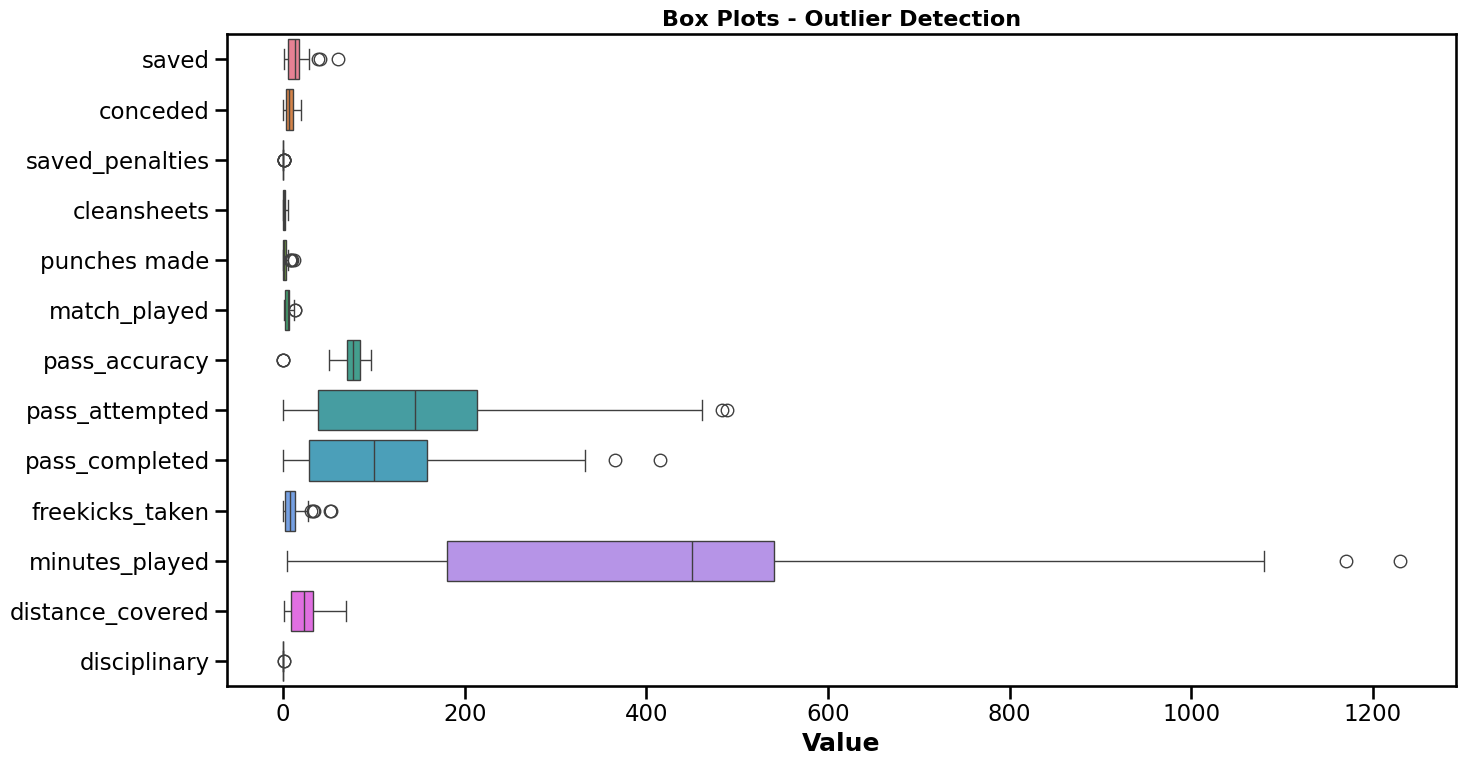

In [25]:
# Boxplots to detect outliers
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[numeric_cols], orient='h')
plt.xlabel('Value', fontweight='bold')
plt.title('Box Plots - Outlier Detection', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

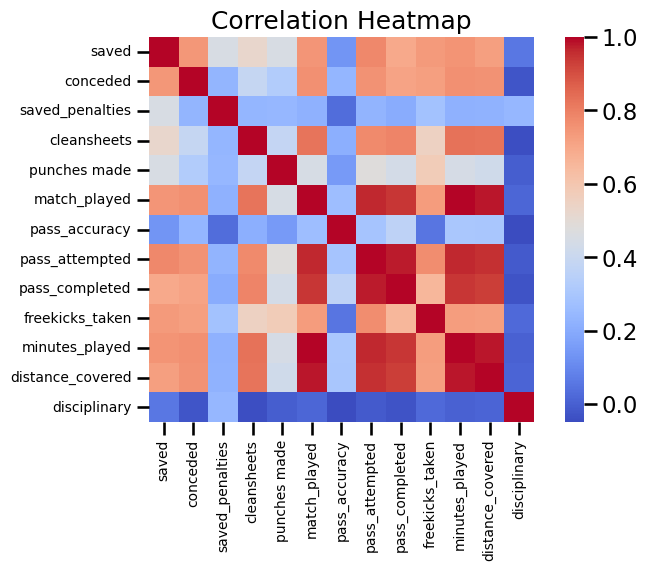

In [26]:
# Correlation matrix heatmap
plt.figure(figsize=(8,5))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap")
# Change font size of axis tick labels
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
plt.show()


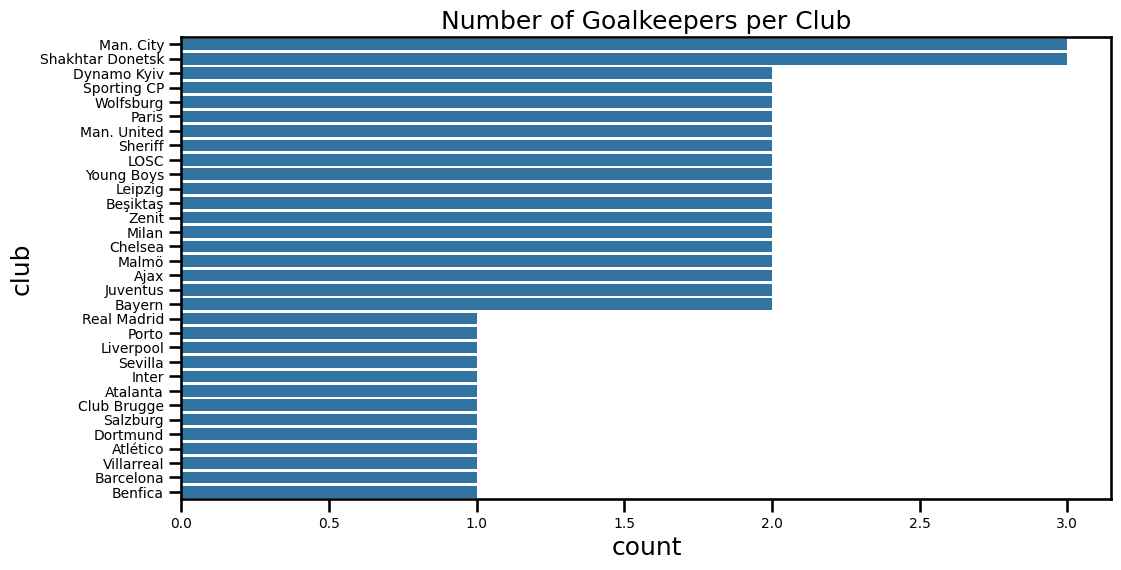

In [27]:
# Categorical feature distributions (club)

plt.figure(figsize=(12,6))
sns.countplot(y='club', data=df, order=df['club'].value_counts().index)
plt.title("Number of Goalkeepers per Club")
# Change font size of axis tick labels
plt.xticks(fontsize=10)  # x-axis values
plt.yticks(fontsize=10)  # y-axis values (club names)
plt.show()

# Factorial Analysis

In [28]:
# # Removing outliers based on domain knowledge
# df = df[df['pass_attempted_per_90'] > 0]

In [29]:
df.drop(columns=['saved_penalties', 'disciplinary'], inplace=True)
numeric_cols = df.select_dtypes(include=[np.number]).columns

In [30]:
df.shape
df.head()

,player_name,club,saved,conceded,cleansheets,punches made,match_played,pass_accuracy,pass_attempted,pass_completed,freekicks_taken,minutes_played,distance_covered
0,Adán,Sporting CP,17,13,2,8,7,70.2,233.0,166.0,34.0,630,36.3
1,Alisson Becker,Liverpool,15,14,4,3,13,89.7,461.0,415.0,16.0,1170,68.8
2,Athanasiadis,Sheriff,29,8,1,2,5,69.2,154.0,106.0,10.0,450,22.7
3,Bounou,Sevilla,14,5,2,1,6,82.2,185.0,152.0,12.0,540,37.2
4,Boyko,Dynamo Kyiv,4,0,1,2,1,74.0,31.0,23.0,2.0,90,4.5


In [31]:
# Compute IQR for each column and filter out extreme values
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Define outlier condition
mask = ~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter dataframe
df_clean = df[mask].copy()

print(f"Before: {len(df)} goalkeepers")
print(f"After removing outliers: {len(df_clean)} goalkeepers")

Before: 53 goalkeepers
After removing outliers: 41 goalkeepers


[0.70154606 0.09541194 0.07332654 0.06572606 0.02389215]
[0.70154606 0.796958   0.87028454 0.9360106  0.95990275]


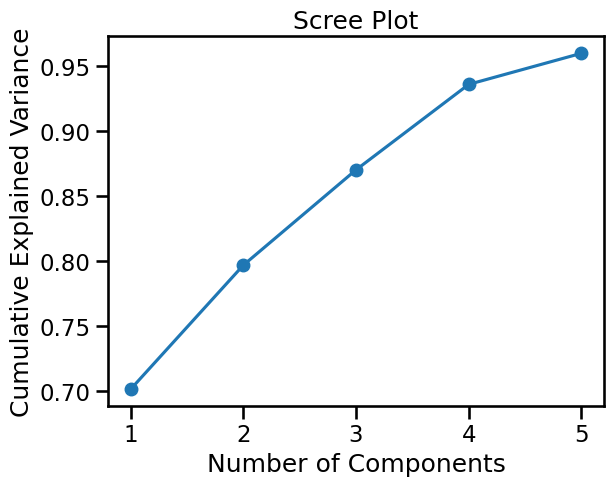

In [32]:
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_cols])  # only numeric columns

# Apply PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()
print(explained_variance)
print(cumulative_variance)

plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

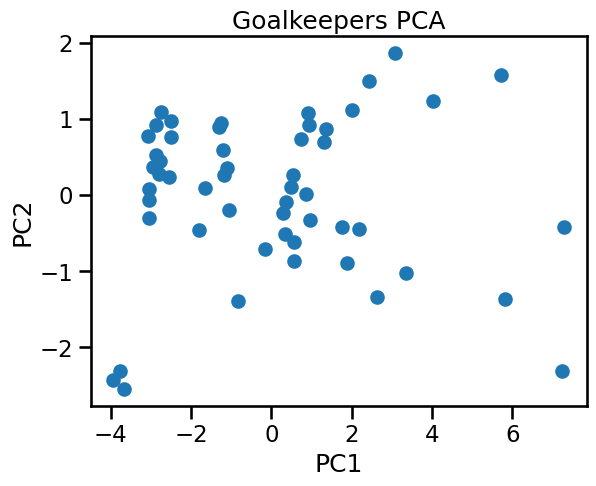

In [33]:

plt.scatter(X_pca[:,0], X_pca[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.title('Goalkeepers PCA')
plt.show()

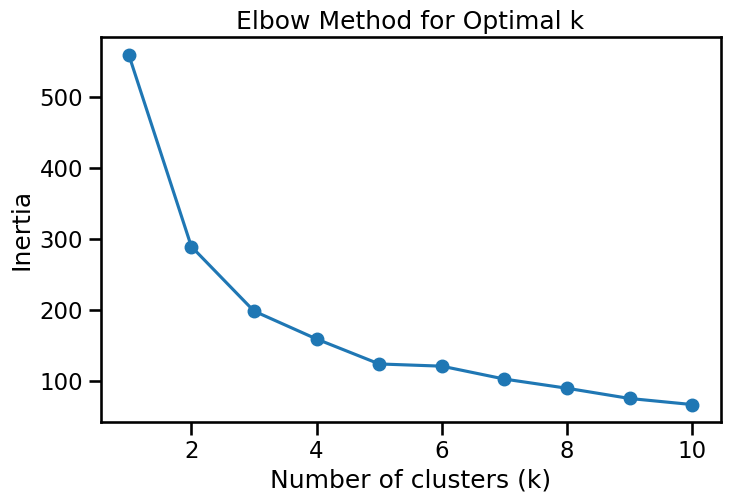

In [34]:
#elbow method to find optimal number of clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


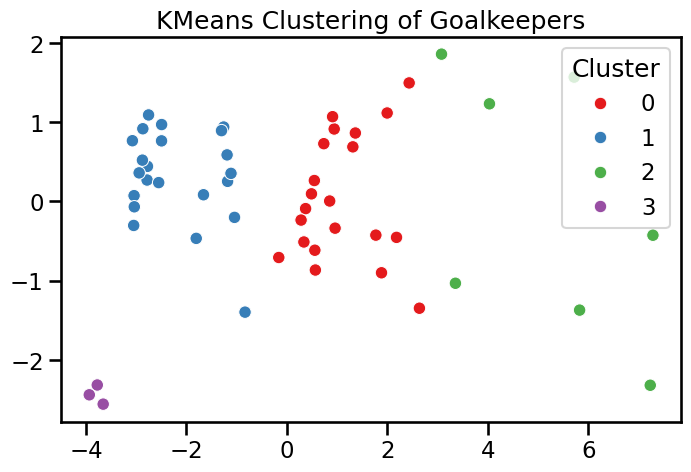

In [35]:
# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_pca)
df['Cluster'] = clusters
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster'], palette='Set1')
plt.title('KMeans Clustering of Goalkeepers')
plt.show()


In [36]:
score = silhouette_score(X_pca, clusters)
print("Silhouette Score:", score)

Silhouette Score: 0.4104712188172259


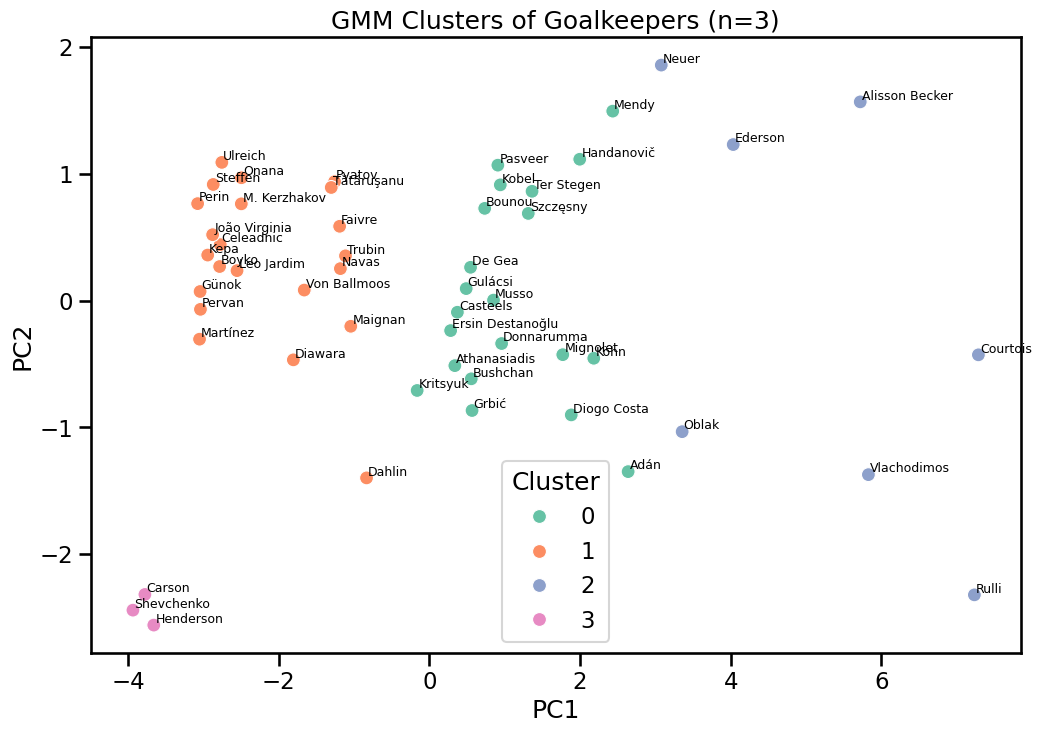

GMM Silhouette Score: 0.40232816054349413


In [37]:
# gaussian mixture model clustering
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_clusters = gmm.fit_predict(X_pca)
df['GMM_Cluster'] = gmm_clusters
# plt.figure(figsize=(8,5))
# sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['GMM_Cluster'], palette='Set2')
# plt.title('GMM Clustering of Goalkeepers')
# plt.show()

plt.figure(figsize=(12,8))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='Set2', s=100, legend='full')

# Add player names as labels
for i, player in enumerate(df['player_name']):
    plt.text(X_pca[i,0]+0.02, X_pca[i,1]+0.02, player, fontsize=9)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'GMM Clusters of Goalkeepers (n=3)')
plt.legend(title='Cluster')
plt.show()


score_gmm = silhouette_score(X_pca, gmm_clusters)
print("GMM Silhouette Score:", score_gmm)

# Mean Shift

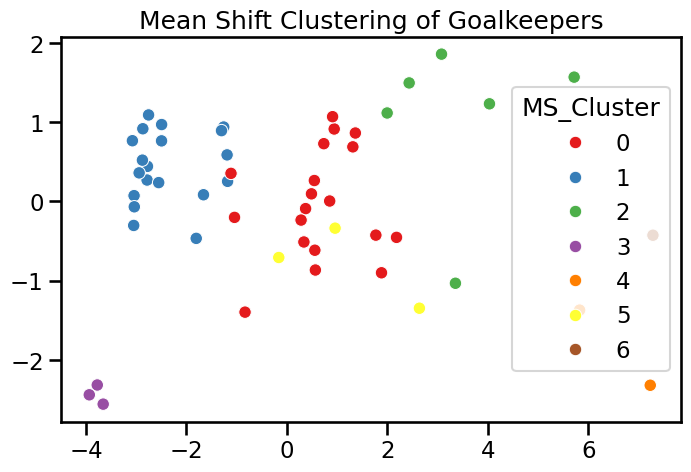

Mean Shift Silhouette Score: 0.4081984650072796


In [38]:
# Mean Shift
bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_clusters = ms.fit_predict(X_pca)
df['MS_Cluster'] = ms_clusters
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['MS_Cluster'], palette='Set1')
plt.title('Mean Shift Clustering of Goalkeepers')
plt.show()
score_ms = silhouette_score(X_pca, ms_clusters)
print("Mean Shift Silhouette Score:", score_ms)